# Milestone 1 - CasierVert952

This data analysis will be conduct on the datasets of two beers rating websites :

- BeerAdvocate
- RateBeer

> *In the following: BeerAdvocate will be abbreviated as BA and RateBeer as RB.*
>
> *The complexe functions that we have designed for this analysis can be found in ```helpers.py```. We import them in the cells where they are needed.*

In [1]:
# Import the basic requiered libraries
import os
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data Preprocessing

### 1.1 Loading CSV data
Let first import the data in CSV format for the two dataset, the users, the beers and the breweries.

In [2]:
# Create Dataframes for the BA dataset
BA_data_path = "data/BeerAdvocate/"

BA_beers = pd.read_csv(BA_data_path + 'beers.csv')
BA_breweries = pd.read_csv(BA_data_path + 'breweries.csv')
BA_users = pd.read_csv(BA_data_path + 'users.csv')

In [3]:
# Create Dataframes for the RB dataset
RB_data_path = "data/RateBeer/"

RB_beers = pd.read_csv(RB_data_path + 'beers.csv')
RB_breweries = pd.read_csv(RB_data_path + 'breweries.csv')
RB_users = pd.read_csv(RB_data_path + 'users.csv')

### 1.2 Transforming the ratings files from TXT to CSV and loading them

You can download the ```ratings.csv``` files for both dataset with the following links (~2GB each):

- For BA : [here](https://coursedingler.ch/data/BA/ratings.csv)
- For RB : [here](https://coursedingler.ch/data/RB/ratings.csv)

The following cell should **NOT** be executed, it only shows how the ```ratings_cleaned.csv``` for each dataset were generated.

It take around 19 minutes to generate the BA ratings file and 14 minutes for the RB one.

```python
from helpers import txt_to_csv

file_txt = 'ratings.txt'
file_csv = 'ratings.csv'

txt_to_csv(BA_data_path + file_txt, BA_data_path + file_csv, "BA")
txt_to_csv(RB_data_path + file_txt, RB_data_path + file_csv, "RB")
```

Then it's time to get the ratings data in Dataframes

**Make sure you have been placed or generated the ```ratings.csv``` files in the ```BeerAdvocate``` and ```RateBeer``` folder as well as all other data files when executing the following cell !**
```
data/
├── BeerAdvocate
│   ├── beers.csv
│   ├── breweries.csv
│   ├── users.csv
│   └── ratings.csv
│
└── RateBeer
    ├── beers.csv
    ├── breweries.csv
    ├── users.csv
    └── ratings.csv
```

In [4]:
# Read the BA ratings file
s_time = time.time()
BA_rating = pd.read_csv(BA_data_path + 'ratings.csv')
e_time = time.time()
print("Reading of BA ratings ended in " + str(e_time - s_time) + " seconds.")

Reading of BA ratings ended in 33.246501207351685 seconds.


In [5]:
# Read the RB ratings file
s_time = time.time()
RB_rating = pd.read_csv(RB_data_path + 'ratings.csv')
e_time = time.time()
print("Reading of RB ratings ended in " + str(e_time - s_time) + " seconds.")

Reading of RB ratings ended in 38.778120279312134 seconds.


In [6]:
print("Size of BA ratings dataset : " + str(BA_rating.shape))
print("Size of RB ratings dataset : " + str(RB_rating.shape))

Size of BA ratings dataset : (8392192, 17)
Size of RB ratings dataset : (7121361, 16)


The ratings datasets contains both more than 7 millions of user's ratings with respectively 17 and 16 features for the BA and RB datasets.

### 1.3 Merging data

#### 1.3.1 Dropping and renaming columns

We are dropping the columns that are not needed, some of them will be recovered during the merging phase. The columns are renamed to avoid colisions during the merges.

In [7]:
from helpers import ratings_dict

# Removing not needed columns
BA_rating.drop(columns=["text", "review"], inplace=True)
RB_rating.drop(columns=["text"], inplace=True)

# Removing columns that will be recovered when merging
BA_rating.drop(columns=["brewery_name", "style", "beer_name", "user_name", "abv"], inplace=True)
RB_rating.drop(columns=["brewery_name", "style", "beer_name", "user_name", "abv"], inplace=True)

# Renaming the columns as define by "ratings_dict"
BA_rating.rename(columns=ratings_dict, inplace=True)
RB_rating.rename(columns=ratings_dict, inplace=True)

#### 1.3.2 Merging with beers 's Data

In [8]:
from helpers import beers_dict

# Merging with the beers's data
BA_merged = pd.merge(BA_rating, BA_beers, on=["beer_id", "brewery_id"], how="inner")
RB_merged = pd.merge(RB_rating, RB_beers, on=["beer_id", "brewery_id"], how="inner")

# Renaming the columns as define by "beers_dict"
BA_merged.rename(columns=beers_dict, inplace=True)
RB_merged.rename(columns=beers_dict, inplace=True)

#### 1.3.3 Merging with breweries's data

In [9]:
from helpers import breweries_dict

# Merging with the breweries's data
BA_merged = pd.merge(BA_merged, BA_breweries, left_on="brewery_id", right_on="id", how="inner")
RB_merged = pd.merge(RB_merged, RB_breweries, left_on="brewery_id", right_on="id", how="inner")

# Dropping the duplicate columns
BA_merged.drop(columns=["id", "name"], inplace=True)
RB_merged.drop(columns=["id", "name"], inplace=True)

# Renaming the columns as define by "breweries_dict"
BA_merged.rename(columns=breweries_dict, inplace=True)
RB_merged.rename(columns=breweries_dict, inplace=True)

#### 1.3.4 Merging with users's data

In [10]:
from helpers import users_dict

# Merging with the users's data
BA_merged = pd.merge(BA_merged, BA_users, on=["user_id"], how="inner")
RB_merged = pd.merge(RB_merged, RB_users, on=["user_id"], how="inner")

# Renaming the columns as define by "users_dict"
BA_merged.rename(columns=users_dict, inplace=True)
RB_merged.rename(columns=users_dict, inplace=True)

### 1.4 Data cleaning

#### 1.4.1 Changing date format

The format of the date field was initialy the timestamp format, here we convert it in a human readable format. We only keep the month and the year as it's the only element we need for our analyses.

In [11]:
# Changing the format of the date of the two datasets to the format "Day-Month-Year" (the format can easily be changed).
BA_cleaned = BA_merged
BA_cleaned["rating_date"] = pd.to_datetime(BA_cleaned["rating_date"], unit='s')
BA_cleaned["rating_date"] = BA_cleaned["rating_date"].dt.strftime("%m-%Y")

RB_cleaned = RB_merged
RB_cleaned["rating_date"] = pd.to_datetime(RB_cleaned["rating_date"], unit='s')
RB_cleaned["rating_date"] = RB_cleaned["rating_date"].dt.strftime("%m-%Y")

#### 1.4.2 Extracting the country and states

Since our analyses will focus on american states, we have to divide the location field in ```country``` and ```state``` columns when possible.

In [12]:
# Let split the "user_location" in country and State fields
split_locations = BA_cleaned['user_location'].str.split(',', expand=True)
BA_cleaned['user_country'] = split_locations[0].str.strip()  # Toujours disponible
BA_cleaned['user_state'] = split_locations[1].str.strip() if split_locations.shape[1] > 1 else None

split_locations = RB_cleaned['user_location'].str.split(',', expand=True)
RB_cleaned['user_country'] = split_locations[0].str.strip()  # Toujours disponible
RB_cleaned['user_state'] = split_locations[1].str.strip() if split_locations.shape[1] > 1 else None

# Dropping the obsolete "user_location" column.
BA_cleaned.drop(columns=["user_location"], inplace=True)
RB_cleaned.drop(columns=["user_location"], inplace=True)

### 1.5 Data visualization
What follow shows how our data looks when merged and cleaned. In the following analysis parts, we will derive some dataframes from ```BA_merged``` and ```RB_merged``` by doing a copy of them, and then removing, modifying and adding feature to these copies.

In [15]:
BA_cleaned.sample(10)

,beer_id,brewery_id,rating_date,user_id,rating_appearance,rating_aroma,rating_palate,rating_taste,rating_overall,rating,...,beer_nbr_matched_valid_ratings,beer_avg_matched_valid_ratings,breweries_location,breweries_nbr_beers,user_nbr_ratings,user_nbr_reviews,user_name,user_join_date,user_country,user_state
2163299,2093,64,05-2014,admonster00.681156,NaN,NaN,NaN,NaN,NaN,4.25,...,0,NaN,"United States, Delaware",378,214,0,admonster00,1.339841e+09,United States,Illinois
4971859,152217,423,03-2015,bb1313.349757,4.00,3.75,4.25,3.75,3.75,3.82,...,0,NaN,"United States, Missouri",140,1536,1536,BB1313,1.247738e+09,United States,Ohio
4396680,3338,347,03-2011,homebrew35.476419,2.50,4.00,2.50,3.00,3.00,3.16,...,0,NaN,"United States, Maine",10,209,204,Homebrew35,NaN,NaN,NaN
7039998,29602,209,01-2016,aglassplease.1083326,3.75,3.75,3.50,3.50,3.25,3.53,...,0,NaN,Ireland,53,65,1,Aglassplease,1.450523e+09,United States,North Carolina
668076,92836,68,02-2015,ciocanelu.691982,3.75,3.75,3.75,3.75,3.75,3.75,...,0,NaN,"United States, Maryland",201,4872,2510,Ciocanelu,1.346321e+09,Romania,None
1806259,86108,396,06-2013,stakem.300923,4.25,4.50,3.75,4.00,3.75,4.06,...,0,NaN,"United States, California",288,4126,3800,stakem,1.235128e+09,United States,Pennsylvania
7722787,115317,20681,08-2016,bourbonagedguru.1168618,4.75,4.75,4.50,4.50,4.50,4.58,...,330,4.682606,"United States, Maine",48,99,0,BourbonAgedGuru,1.470391e+09,United States,Wisconsin
4760290,1157,1146,11-2011,kiniey01.120497,NaN,NaN,NaN,NaN,NaN,3.00,...,0,NaN,"United States, Illinois",869,1520,0,Kiniey01,1.170500e+09,United States,Texas
6353210,48134,287,11-2016,crimsonfloyd.1124853,4.00,4.25,3.75,3.50,3.75,3.79,...,0,NaN,"United States, Michigan",312,97,97,crimsonfloyd,1.458904e+09,United States,California
7743236,74903,24815,08-2014,alexbassberger.852067,NaN,NaN,NaN,NaN,NaN,4.00,...,4,4.110000,"United States, Minnesota",29,96,0,AlexBassBerger,1.408961e+09,United States,California


## 2 Data exploration of both datasets

Indeed, we are given two different but very similar datasets to perform our analysis. Let's begin by examining them to determine the best approach: using one dataset, combining both, or creating a blend of the two.

### 2.1 Sizes

We will firstly interrest ourself to their size

In [16]:
# Printing the sizes of each Dataframe for both datasets.
print("BA :")
print("   Number of ratings   : " + str(BA_merged.shape[0]))
print("   Number of beers     : " + str(BA_beers.shape[0]))
print("   Number of breweries : " + str(BA_breweries.shape[0]))
print("   Number of users     : " + str(BA_users.shape[0]))
print("\nRB :")
print("   Number of ratings   : " + str(RB_merged.shape[0]))
print("   Number of beers     : " + str(RB_beers.shape[0]))
print("   Number of breweries : " + str(RB_breweries.shape[0]))
print("   Number of users     : " + str(RB_users.shape[0]))

BA :
   Number of ratings   : 8392192
   Number of beers     : 280823
   Number of breweries : 16758
   Number of users     : 153704

RB :
   Number of ratings   : 7123070
   Number of beers     : 442081
   Number of breweries : 24189
   Number of users     : 70174


The RB dataset contains more data on different beers and breweries, but less users than the BA one. Both datasets have more than 7 millions of user's ratings, which seems enough to perfom our analysis.

### 2.2 Country Representation

As our study will mainly focus on specific countries (the USA and European ones), we investigate the representation of countries in both datasets. This will assist us in selecting the most appropriate dataset for our final analyses.

In [17]:
# First we will see what part of the datasets doesn't have the country field filled
BA_nan_location = BA_cleaned['user_country'].isna()
print("BA: \n   " + str(BA_nan_location.sum()) + " missing country -> " + str(round(BA_nan_location.mean() * 100, 2)) + "%")

RB_nan_location = RB_cleaned['user_country'].isna()
print("RB: \n   " + str(RB_nan_location.sum()) + " missing country -> " + str(round(RB_nan_location.mean() * 100, 2)) + "%")

BA: 
   500223 missing country -> 5.96%
RB: 
   203670 missing country -> 2.86%


In [18]:
# TODO : Dois je retirer les NAN location maintenant ? Durant le data cleaning ? Après ? Samuel la fait dans sa partie après
#BA_cleaned = BA_cleaned.dropna(subset=['user_country'])
#RB_cleaned = RB_cleaned.dropna(subset=['user_country'])

In [19]:
# TODO : Echelle lineair ou log ? Le pote à Daniel avait mis lineair, mais log est plus joli :) On se rend moins compte que
# il y a que des ratings USA mais les données sont plus lisibles

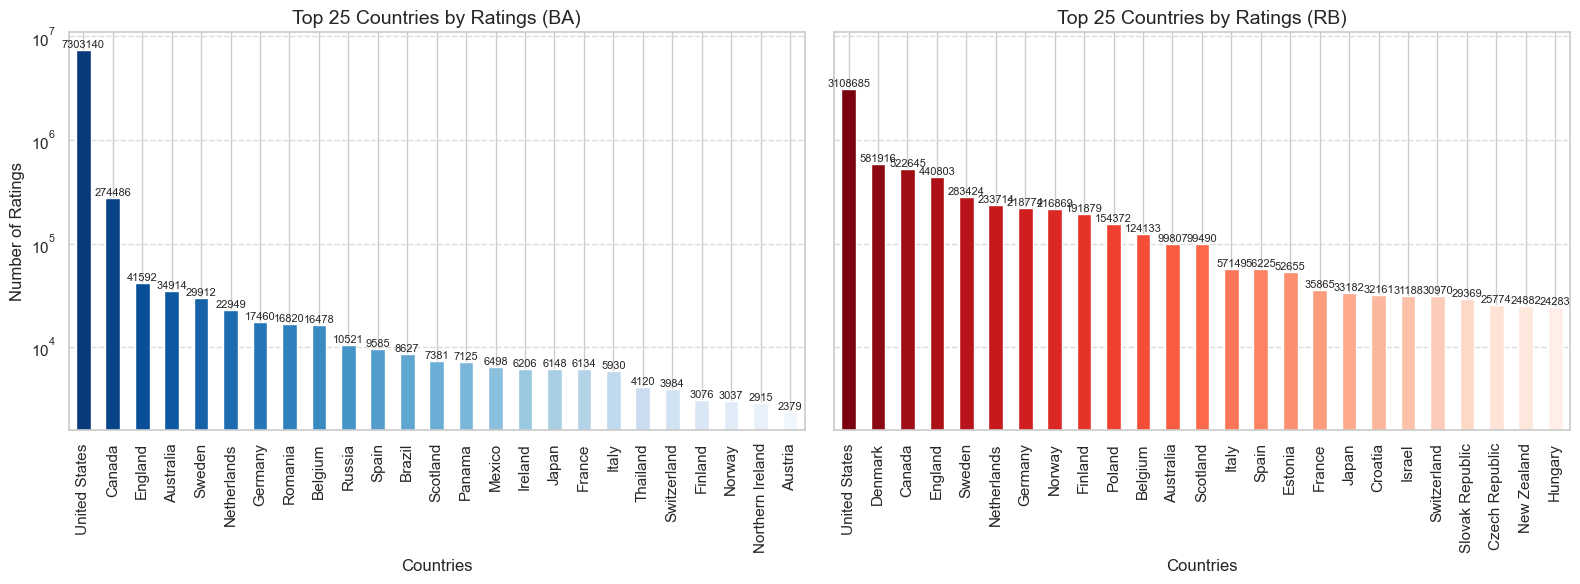

In [20]:
from helpers import ploting_country_representation

# Calculer le nombre de ratings par pays pour chaque DataFrame
BA_count_per_country = BA_cleaned.groupby('user_country').size().nlargest(25)
RB_count_per_country = RB_cleaned.groupby('user_country').size().nlargest(25)

ploting_country_representation(BA_count_per_country, RB_count_per_country, 'log')

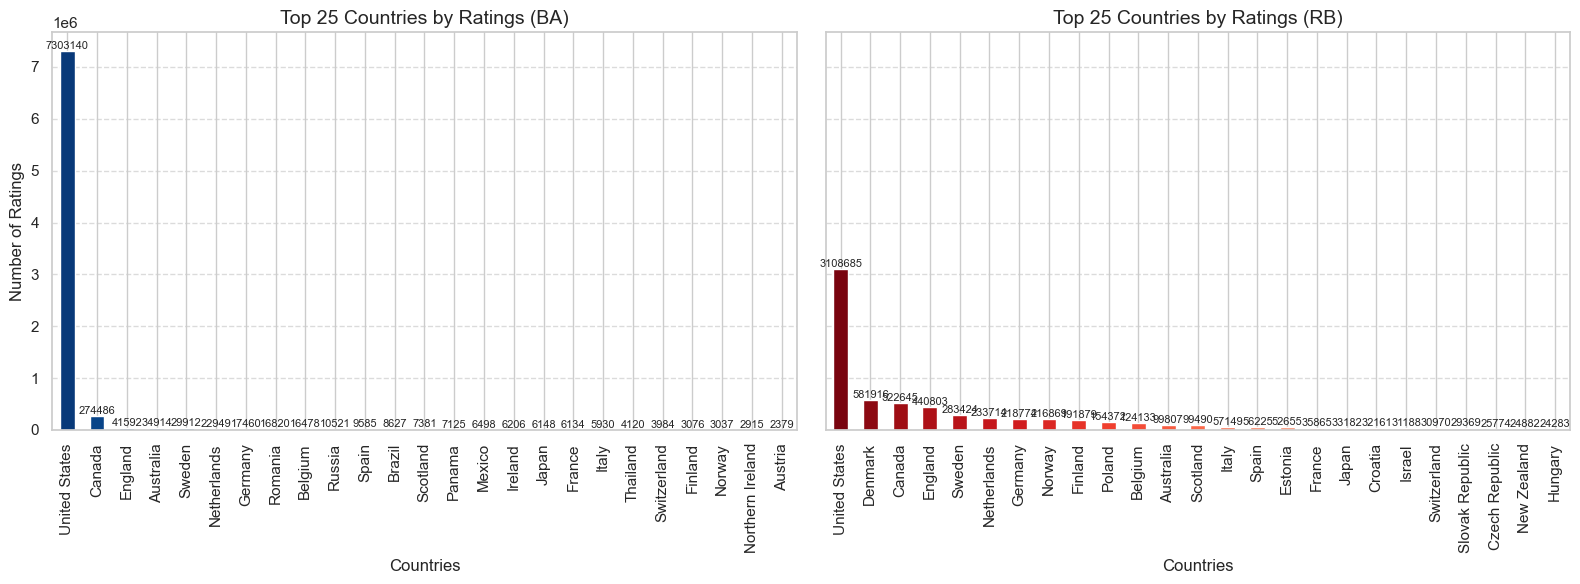

In [21]:
from helpers import ploting_country_representation

# Calculer le nombre de ratings par pays pour chaque DataFrame
BA_count_per_country = BA_cleaned.groupby('user_country').size().nlargest(25)
RB_count_per_country = RB_cleaned.groupby('user_country').size().nlargest(25)

ploting_country_representation(BA_count_per_country, RB_count_per_country, 'linear')

In [22]:
# Country ratings with precise values
country_comparison = pd.DataFrame({
    'Country (BA)': BA_count_per_country.index,
    '# of Ratings (BeerAdvocate)': BA_count_per_country.values,
    '% of Ratings (BeerAdvocate)': np.round(BA_count_per_country.values / len(BA_cleaned) * 100, 2),
    'Country (RB)': RB_count_per_country.index,
    '# of Ratings (RateBeer)': RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values,
    '% of Ratings (RateBeer)': np.round(RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values / len(RB_cleaned) * 100, 2)
})
country_comparison.index = range(1, len(country_comparison) + 1)
country_comparison.head(10)

,Country (BA),# of Ratings (BeerAdvocate),% of Ratings (BeerAdvocate),Country (RB),# of Ratings (RateBeer),% of Ratings (RateBeer)
1,United States,7303140,87.02,United States,3108685,43.64
2,Canada,274486,3.27,Denmark,581916,8.17
3,England,41592,0.50,Canada,522645,7.34
4,Australia,34914,0.42,England,440803,6.19
5,Sweden,29912,0.36,Sweden,283424,3.98
6,Netherlands,22949,0.27,Netherlands,233714,3.28
7,Germany,17460,0.21,Germany,218774,3.07
8,Romania,16820,0.20,Norway,216869,3.04
9,Belgium,16478,0.20,Finland,191879,2.69
10,Russia,10521,0.13,Poland,154372,2.17


As evident from the plots and tables above, the BA dataset mainly consists of ratings from the US, while the RB dataset contains a more balanced distribution, with approximately half of the ratings originating from the US and the other half from European countries.

Based on these results, it would be adequate to utilize the BA dataset for our analyses focused on the US, while the RB dataset would be more suitable for our analyses concerning Europe.

In [ ]:
# TODO : Que fait de plus dans l'exploration des données

### 2.3 Conclusion on data exploration

Now that we have observed the two datasets in details, .......

## 3 Analysis : Relation Beer vs Political

Partie de Samuel pour creer un dataframe pour les USA et commencer les analyses.

In [25]:
#Create Dataframe of only USA users
RB_usa = RB_merged.copy()[RB_merged['user_country'].str.contains('United States', case=False, na=False)]
BA_usa = BA_merged.copy()[BA_merged['user_country'].str.contains('United States', case=False, na=False)]

In [26]:
RB_other = RB_merged.copy()[~RB_merged['user_country'].str.contains('United States', case=False, na=False)]
BA_other = BA_merged.copy()[~BA_merged['user_country'].str.contains('United States', case=False, na=False)]

In [ ]:
#Top ten beer for users of different states
#Democrats States
RB_california = RB_usa.copy()[RB_usa['user_location']=='United States, California']
RB_california[['beer_name','breweries_location','rating']].groupby(['beer_name']).agg({'rating': 'mean','breweries_location': 'first'}).sort_values('rating',ascending=False)[:10]

RB_massachusetts = RB_usa.copy()[RB_usa['user_location']=='United States, Massachusetts']
RB_massachusetts[['beer_name','breweries_location','rating']].groupby(['beer_name']).agg({'rating': 'mean','breweries_location': 'first'}).sort_values('rating',ascending=False)[:10]

#Republican States
RB_alabama = RB_usa.copy()[RB_usa['user_location']=='United States, Alabama']
RB_alabama[['beer_name','breweries_location','rating']].groupby(['beer_name']).agg({'rating': 'mean','breweries_location': 'first'}).sort_values('rating',ascending=False)[:10]

RB_indiana = RB_usa.copy()[RB_usa['user_location']=='United States, Indiana']
RB_indiana[['beer_name','breweries_location','rating']].groupby(['beer_name']).agg({'rating': 'mean','breweries_location': 'first'}).sort_values('rating',ascending=False)[:10]

# EN DESSOUS, Cellules de tests, à retirer !!!

In [23]:
with open('data/BeerAdvocate/ratings.txt', 'r') as fichier:
    for i, ligne in enumerate(fichier):
        if i >= 100000:  # Arrête la boucle après 100 lignes
            break
        print(ligne.strip())

beer_name: RÃ©gab
beer_id: 142544
brewery_name: Societe des Brasseries du Gabon (SOBRAGA)
brewery_id: 37262
style: Euro Pale Lager
abv: 4.5
date: 1440064800
user_name: nmann08
user_id: nmann08.184925
appearance: 3.25
aroma: 2.75
palate: 3.25
taste: 2.75
overall: 3.0
rating: 2.88
text: From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse.
review: True

beer_name: Barelegs Brew
beer_id: 19590
brewery_name: Strangford Lough Brewing Company Ltd
brewery_id: 10093
style: English Pale Ale
abv: 4.5
date: 1235127600
user_name: StJamesGate
user_id: stjamesgate.163714
appearance: 3.0
aroma: 3.5
palate: 3.5
taste: 4.0
overall: 3.5
rating: 3.67
text: Pours pale copper with a thin head that quickly goes. Caramel, golden syru

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 2599: character maps to <undefined>